In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [194]:
df = pd.read_csv('../data/telecom_clean.csv')

In [195]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


In [196]:
df.shape

(5986, 20)

In [197]:
np.random.seed(10)

In [198]:
df['Churn'].value_counts()

No     4399
Yes    1587
Name: Churn, dtype: int64

In [199]:
remove_n = 1200
drop_indices = np.random.choice(df.loc[lambda d: d['Churn']=='Yes'].index, remove_n, replace=False)

In [200]:
df = df.drop(drop_indices)

<AxesSubplot:xlabel='Churn', ylabel='count'>

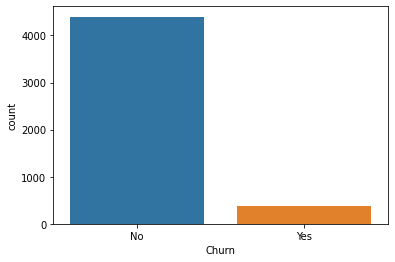

In [201]:
sns.countplot(df['Churn'])

In [202]:
df['Churn'].value_counts()

No     4399
Yes     387
Name: Churn, dtype: int64

In [203]:
base_accuracy = 4399/(4399+387)

In [204]:
base_accuracy

0.9191391558712912

In [206]:
df.to_csv('churn_telecom.csv')

-----

In [13]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [14]:
from sklearn.base import TransformerMixin, BaseEstimator

class DTypeSelector(BaseEstimator, TransformerMixin):

    def __init__(self, dtypes):
        self.dtypes = dtypes


    def fit(self, X, y):
        return self


    def transform(self, X):
        return X.select_dtypes(self.dtypes)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = df.drop(columns='Churn')

In [17]:
y = df['Churn']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
import keras

In [20]:
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [21]:
def create_model(optimizer='adam'):
    model = Sequential()
    
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy', keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')])
    
    return model

In [22]:
pipeline = make_pipeline(
    make_union(
        make_pipeline(
        DTypeSelector('number'),
        SimpleImputer(),
        StandardScaler()
    ),
        make_pipeline(
        DTypeSelector('object'),
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder()
    )
    ),
    KerasClassifier(build_fn=create_model,verbose=1, epochs=100, batch_size=32)
)

In [23]:
pipeline.fit(X_train, y_train)

Epoch 1/100
101/101 [==============================] - 1s 1ms/step - loss: 0.3066 - accuracy: 0.9297 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2326 - accuracy: 0.9181 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2038 - accuracy: 0.9260 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2155 - accuracy: 0.9150 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2060 - accuracy: 0.9215 - precision: 0.5645 - recall: 0.0114  
Epoch 6/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2230 - accuracy: 0.9138 - precision: 0.7070 - recall: 0.0145  
Epoch 7/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2257 - accuracy: 0.9136 - precision: 0.6592 - recall: 0.120

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('dtypeselector',
                                                                  DTypeSelector(dtypes='number')),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                missing_values=nan,
                                                                                strategy='mean',
                 

In [24]:
y_preds = pipeline.predict(X_test)
y_preds_training = pipeline.predict(X_train)

101/101 [==============================] - 0s 703us/step


In [25]:
y_preds

array([['No'],
       ['No'],
       ['No'],
       ...,
       ['No'],
       ['No'],
       ['No']], dtype=object)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(classification_report(y_train, y_preds_training))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      2950
         Yes       0.97      0.80      0.88       256

    accuracy                           0.98      3206
   macro avg       0.97      0.90      0.93      3206
weighted avg       0.98      0.98      0.98      3206



In [28]:
confusion_matrix(y_train, y_preds_training)

array([[2943,    7],
       [  51,  205]])

In [29]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

          No       0.93      0.95      0.94      1449
         Yes       0.31      0.22      0.26       131

    accuracy                           0.89      1580
   macro avg       0.62      0.59      0.60      1580
weighted avg       0.88      0.89      0.89      1580



In [30]:
confusion_matrix(y_test, y_preds)

array([[1383,   66],
       [ 102,   29]])

# AutoKeras

In [97]:
from autokeras import StructuredDataClassifier

In [98]:
import tensorflow as tf

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [87]:
import kerastuner

import autokeras as ak

from tensorflow.keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [100]:
clf = StructuredDataClassifier(
    max_trials=10,
    overwrite=True
)

In [88]:
# clf = StructuredDataClassifier(
#     max_trials=5,
#     overwrite=True,
#     objective=kerastuner.Objective('val_f1_score', direction='max'),
#     metrics=[f1_score]
# )

In [101]:
clf.fit(x=X_train, y=y_train, epochs=100)

Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.9169381260871887

Best val_accuracy So Far: 0.9250814318656921
Total elapsed time: 00h 02m 21s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
101/101 [==============================] - 1s 1ms/step - loss: 0.3743 - accuracy: 0.8855
Epoch 2/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2566 - accuracy: 0.9261
Epoch 3/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2455 - accuracy: 0.9261
Epoch 4/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2389 - accuracy: 0.9261
Epoch 5/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2343 - accuracy: 0.9263
Epoch 6/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2307 - accuracy: 0.9262
Epoch 7/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2274 - accuracy: 0.9267
Epoch 8/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2248 - accuracy: 0.9267
Epoch 9/100

In [104]:
predicted_y = clf.predict(X_test)

In [105]:
predicted_y

array([['No'],
       ['No'],
       ['No'],
       ...,
       ['No'],
       ['No'],
       ['No']], dtype='<U3')

In [106]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

          No       0.93      0.96      0.95      1449
         Yes       0.36      0.22      0.27       131

    accuracy                           0.90      1580
   macro avg       0.65      0.59      0.61      1580
weighted avg       0.88      0.90      0.89      1580



# Own model

In [174]:
import sklearn

In [175]:
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

In [176]:
# Count samples per class
classes_churn = df[df['Churn'] == 'Yes']
classes_no_churn = df[df['Churn'] == 'No']

# Convert parts into NumPy arrays for weight computation
churn_numpy = classes_churn['Churn'].to_numpy()
no_churn_numpy = classes_no_churn['Churn'].to_numpy()
all_together = np.concatenate((churn_numpy, no_churn_numpy))
unique_classes = np.unique(all_together)

In [177]:
weights = sklearn.utils.class_weight.compute_class_weight('balanced', unique_classes, all_together)

In [179]:
def create_model(optimizer='adam'):
    model = Sequential()
    
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy', keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')])
    
    return model

In [180]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [186]:
pipeline = make_pipeline(
    make_union(
        make_pipeline(
        DTypeSelector('number'),
        SimpleImputer(),
        StandardScaler()
    ),
        make_pipeline(
        DTypeSelector('object'),
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder()
    )
    ),
    KerasClassifier(build_fn=create_model,verbose=1, epochs=100, batch_size=32, callbacks=[early_stopping])
)

In [187]:
pipeline.fit(X_train, y_train)

Epoch 1/100
101/101 [==============================] - 1s 1ms/step - loss: 0.3706 - accuracy: 0.8412 - precision: 0.1100 - recall: 0.1198
Epoch 2/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2240 - accuracy: 0.9234 - precision: 0.2704 - recall: 0.0034   
Epoch 3/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2142 - accuracy: 0.9251 - precision: 0.6849 - recall: 0.0212  
Epoch 4/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2114 - accuracy: 0.9223 - precision: 0.3415 - recall: 0.0078  
Epoch 5/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2239 - accuracy: 0.9171 - precision: 0.5441 - recall: 0.0041  
Epoch 6/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2174 - accuracy: 0.9211 - precision: 0.2993 - recall: 0.0059  
Epoch 7/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2129 - accuracy: 0.9220 - precision: 0.8711 - recall: 0.0571
Epoch 8/100
101/101 [==

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('dtypeselector',
                                                                  DTypeSelector(dtypes='number')),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                missing_values=nan,
                                                                                strategy='mean',
                 

In [188]:
y_preds = pipeline.predict(X_test)
y_preds_training = pipeline.predict(X_train)

101/101 [==============================] - 0s 640us/step


In [189]:
print(classification_report(y_train, y_preds_training))

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      2950
         Yes       0.95      0.74      0.83       256

    accuracy                           0.98      3206
   macro avg       0.96      0.87      0.91      3206
weighted avg       0.98      0.98      0.97      3206



In [190]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

          No       0.93      0.98      0.95      1449
         Yes       0.33      0.14      0.19       131

    accuracy                           0.91      1580
   macro avg       0.63      0.56      0.57      1580
weighted avg       0.88      0.91      0.89      1580



-----